<a href="https://colab.research.google.com/github/Priya-0117/Portfolio/blob/main/Spotify_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This template is used for discussion of the project

### Your team should be using this cell to:
* Provide a business description of what your project does (not just listing the functions you created)
* Lists the team members who worked on the project - THIS SHOULD BE AT THE END OF THE PROJECT, AFTER TEAM MEMBERS HAVE MADE A CONTRIBUTION. This should agree with the form your team submits at the end with the effort level by team members.
* Describes the data you are using, and ideally provides a link to the website where you can get the data or the tools used to get the data.
* If you are bringing in other modules, where you intoduce them, include a link to documentation.

###The top of the project should then:
* Install the spotipy module in its own cell
* Do any imports you need throughout the project.  This will allow you to run this one cell if you need to add an import or use an import someone else on the team is already importing.

**NOTE ON USING MARKDOWN:** The use of headers in Markdown (# starts a "header 1" HTML tag, ## starts a "header 2" HTML tag, etc. up to 6 levels.  Use levels consistently and Colab will build an indented table of contents for you in the toolbar on the left (the bullet list icon).

The name of your team:

**The Beginners**

The names of team members who participated:

*   Yung-Ching Chang
*   Jasmine Du
*   Khushi Khasgiwala
*   Sathvika Chakka





# Setup




####installing spotify



In [ ]:
pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




#### all imports


In [ ]:
import getpass
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pprint
pp = pprint.PrettyPrinter(indent=4, width=80)

# get_spotify

**Programming Notes:**
* prompts for the users id and secret
* if the input is invalid, gives user 3 more tries to input their client id and secret.

In [ ]:
def get_spotify():
    for tries in range(1,4):
        try:
            client_id = input("Please enter your Client ID: ")
            client_secret = getpass.getpass ("Please enter your Client Secret: ")

            client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
            sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

            sp.available_markets()
            return sp

        except spotipy.oauth2.SpotifyOauthError as ex:
            print(f"Attempt {tries} of 3: Unable to connect to Spotify. "
            "Please check your Client ID and Client Secret.")
    print("After 3 tries unable to connect.")
    return None

# get_categories

*   Prints out all the category names to the user
*   Collects input for two categories and gives out their ids







In [ ]:
import pprint
def get_categories(sp):
    categories = sp.categories(limit=50)['categories']['items']

    while True:
        next_categories = sp.categories(limit=50, offset=len(categories))['categories']['items']
        if not next_categories:
            break
        categories.extend(next_categories)

    categories = sorted(categories, key=lambda c: c['name'])

    print('Spotify categories to select from:')
    for i in range(0, len(categories), 5):
        row_categories = categories[i:i+5]
        row_names = [c['name'] for c in row_categories]
        row_names += [''] * (5 - len(row_names))  # Fill the rest with empty strings
        print("{:<25} {:<25} {:<25} {:<25} {:<25}".format(*row_names))
    print("")

    while True:
        first_category_name = input("Enter first category name:").lower()
        matching_categories = [c for c in categories if c['name'].lower() == first_category_name]
        if len(matching_categories) == 1:
            first_category_id = matching_categories[0]['id']
            break
        else:
            print("Invalid category name. Please enter a valid category name.")

    while True:
        second_category_name = input("Enter second category name:").lower()
        matching_categories = [c for c in categories if c['name'].lower() == second_category_name]
        if len(matching_categories) == 1:
            second_category_id = matching_categories[0]['id']
            break
        else:
            print("Invalid category name. Please enter a valid category name.")
    try:
        sp.category(first_category_id)
        sp.category(second_category_id)
    except:
        print('Invalid category ID. Please try again.')
        return get_categories(sp)

    category_selected = {first_category_name: first_category_id, second_category_name: second_category_id}
    print(category_selected)
    return category_selected

# category_id

In [ ]:
def get_category_id(sp):
    categories = sp.categories(limit=50, country='US')['categories']['items']
    for i, category in enumerate(categories):
        print(f"{i}: {category['name']}")
    choice = int(input("Enter the number of the category you want to process: "))
    return categories[choice]['id']

###get_playlists

* the parameters sp and playlist_id are the signatures of the function
* the playlists from the two categories are retrived and the total number of followers, tracks, id, and name are returned.

In [ ]:
def get_playlists(sp, playlist_id):
    playlist = sp.playlist(playlist_id)
    get_playlist = {
        'id': playlist['id'],
        'name': playlist['name'],
        'followers': playlist['followers']['total'],
        'total_tracks': playlist['tracks']['total']
    }
    return get_playlist

###process_tracks
*   Called by process_category
*   Gives out avg duration, avg explicit, and avg popularity for a particular playlist




In [ ]:
def process_tracks(sp, playlist_id):
    tracks = sp.playlist_tracks(playlist_id)
    total_duration = 0
    total_explicitness = 0
    total_popularity = 0
    track_count = 0
    for track in tracks['items']:
        if track['track'] is not None:
            total_duration += track['track'].get('duration_ms', 0)
            total_explicitness += int(track['track'].get('explicit', False))
            total_popularity += track['track'].get('popularity', 0)
            track_count += 1
    avg_duration = total_duration / track_count if track_count > 0 else 0
    avg_explicitness = total_explicitness / track_count if track_count > 0 else 0
    avg_popularity = total_popularity / track_count if track_count > 0 else 0
    return {
        'avg_duration': avg_duration,
        'avg_explicit': avg_explicitness,
        'avg_popularity': avg_popularity
    }

# process_category

* calls get_playlists and process_tracks
* parameters are sp and category_id of each selected category
* returns id, name, total tracks, followers, average duration, average explicit, and average popularity for each playlist and tracks in the selected category

In [ ]:
def process_category(sp, category_id):
    playlists_response = sp.category_playlists(category_id=category_id, country='US', limit=50, offset=0)
    playlists = playlists_response['playlists']['items']

    processed_playlists = []

    # For each playlist, get the total number of tracks and followers
    for playlist in playlists:
        if playlist is None:
            continue
        try:
            playlist_details = sp.playlist(playlist['id'])
            track_stats = process_tracks(sp, playlist['id'])
            processed_playlists.append({
                'id': playlist['id'],
                'name': playlist['name'],
                'total_tracks': playlist_details['tracks']['total'],
                'followers': playlist_details['followers']['total'],
                'avg_duration': track_stats['avg_duration'],
                'avg_explicit': track_stats['avg_explicit'],
                'avg_popularity': track_stats['avg_popularity'],
            })
        except TypeError:
            print(f"Error processing playlist: {playlist}")
            continue
    return processed_playlists

#compare_categories
* uses categories_data as its parameter
* takes the data from process_category and returns it as 5 box plots including two categories in each graph.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def compare_categories(categories_data):
    category = []
    explicit = []
    followers = []
    duration = []
    popularity = []
    tracks = []

    for category_name, playlist_list in categories_data.items():
        for playlist in playlist_list:
            category.append(category_name)
            tracks.append(playlist.get('total_tracks', 0))
            followers.append(playlist.get('followers', 0))
            duration.append(playlist.get('avg_duration', 0))
            popularity.append(playlist.get('avg_popularity', 0))
            explicit.append(playlist.get('avg_explicit', 0))

    plt.figure()
    sns.boxplot(x=category, y=tracks)
    plt.figure()
    sns.boxplot(x=category, y=followers)
    plt.figure()
    sns.boxplot(x=category, y=duration)
    plt.figure()
    sns.boxplot(x=category, y=popularity)
    plt.figure()
    sns.boxplot(x=category, y=explicit)

    plt.show()


* data of both categories is combined into one dictionary

In [ ]:
category1_data = process_category(sp, category1_id)
category2_data = process_category(sp, category2_id)

# Combine the data into a dictionary
categories_data = {
    category1_name: category1_data,
    category2_name: category2_data,
}

# Main Program


### Prompt user to enter their client ID and client Secret

In [ ]:
sp = get_spotify()
if sp is not None:
    sp.categories()

Please enter your Client ID: 1820a50b999e46d99d20e6ba059348f6
Please enter your Client Secret: ··········



### Select two categories
*   prints a list of categories for the user to select from.
* user can select two categories


In [ ]:
category_selected = get_categories(sp)

Spotify categories to select from:
Afro                      Alternative               Ambient                   Anime                     Arab                     
Blues                     Caribbean                 Chill                     Christian & Gospel        Classical                
Comedy                    Cooking & Dining          Country                   Dance/Electronic          Decades                  
Desi                      EQUAL                     Focus                     Folk & Acoustic           Frequency                
Fresh Finds               Funk & Disco              Gaming                    Hip-Hop                   In the car               
Indie                     Instrumental              Jazz                      K-Pop                     Kids & Family            
Latin                     Metal                     Mood                      Netflix                   Party                    
Pop                       Pop culture               Pri

In [ ]:
category_ids = list(category_selected.values())
category_names = list(category_selected.keys())

category1_id = category_ids[0]
print(category1_id)

category2_id = category_ids[1]
print(category2_id)

category1_name = category_names[0]
print(category1_name)

category2_name = category_names[1]
print(category2_name)

0JQ5DAqbMKFQ1UFISXj59F
in_the_car
arab
in the car


### Compares playlist data within the two selected categories



* the playlists of the two categories selected by the user is retrived
* the data of the playlist is condensed and displayed
* the display is a comparasion of the number of tracks, followers, duration, popularity, and explicity of the playlists.



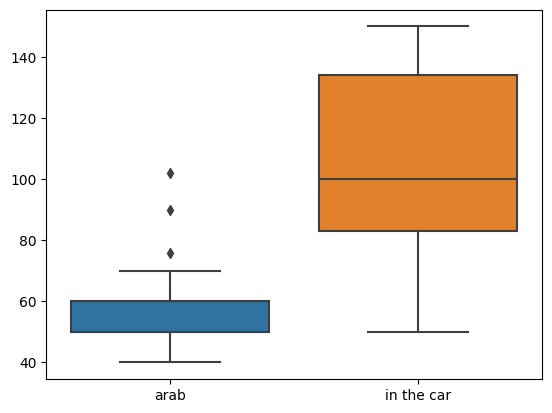

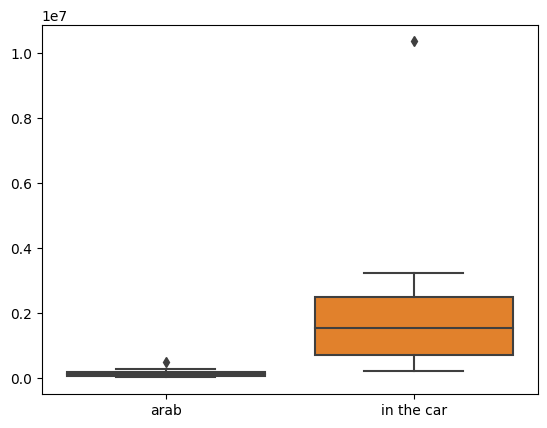

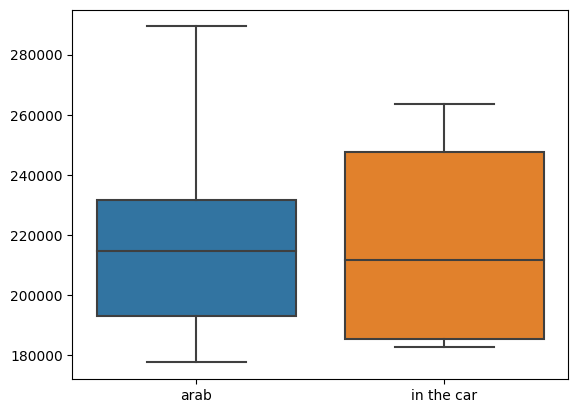

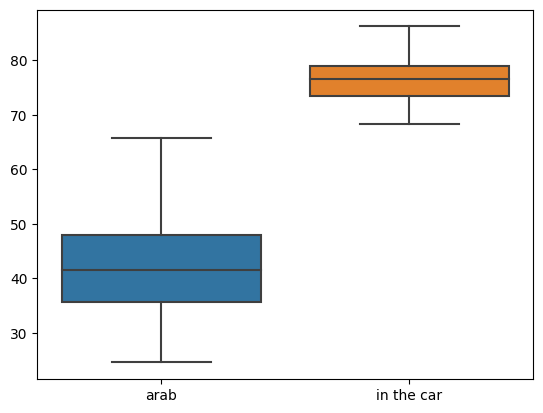

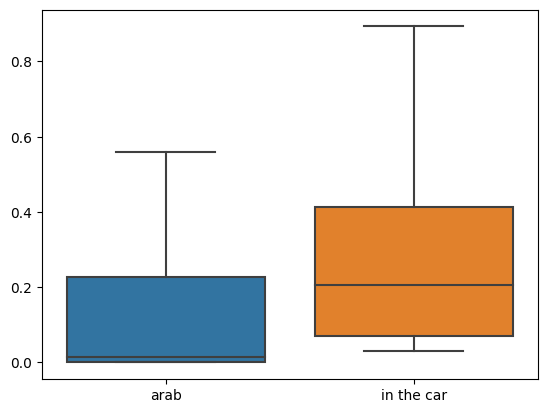

In [ ]:
# Now you can call compare_categories
compare_categories(categories_data)